Test

In [1]:
import pickle
import numpy as np
import xarray as xr
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import matplotlib.path as mpath
import classify_from_polygon as cfp
import cmocean

In [2]:
#----- Load files -----
IBCSO = xr.open_dataset('/home/users/birgal/data/input_data/topo/IBCSO_v2_bed_WGS84.nc') # Bathymetry
with open('/home/users/birgal/data/IBCSO_isobath_2000m_polygon', "rb") as poly_file:     # Load polygon from disc
    isobath_2000m_polygon = pickle.load(poly_file)

# ---- Setup run ----
# Latitude and longitude grid points to classify
x_IBCSO, y_IBCSO = np.meshgrid(IBCSO['lon'], IBCSO['lat'])
x_test = x_IBCSO[::100,::100].flatten()
y_test = y_IBCSO[::100,::100].flatten()

# ---- Run classification ----

%time boolean_test = cfp.coord_in_polygon(x_test, y_test, isobath_2000m_polygon, n_chunks=20)

CPU times: user 4.28 s, sys: 6.44 ms, total: 4.29 s
Wall time: 4.3 s


In [3]:
%time boolean_test = cfp.coord_in_polygon_parallel(x_test, y_test, isobath_2000m_polygon, n_chunks=5)

CPU times: user 173 ms, sys: 331 ms, total: 504 ms
Wall time: 2.12 s


/home/users/birgal/analysis-birgal/nemo_config_debugging/classify_from_polygon.py:93: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(boolean)


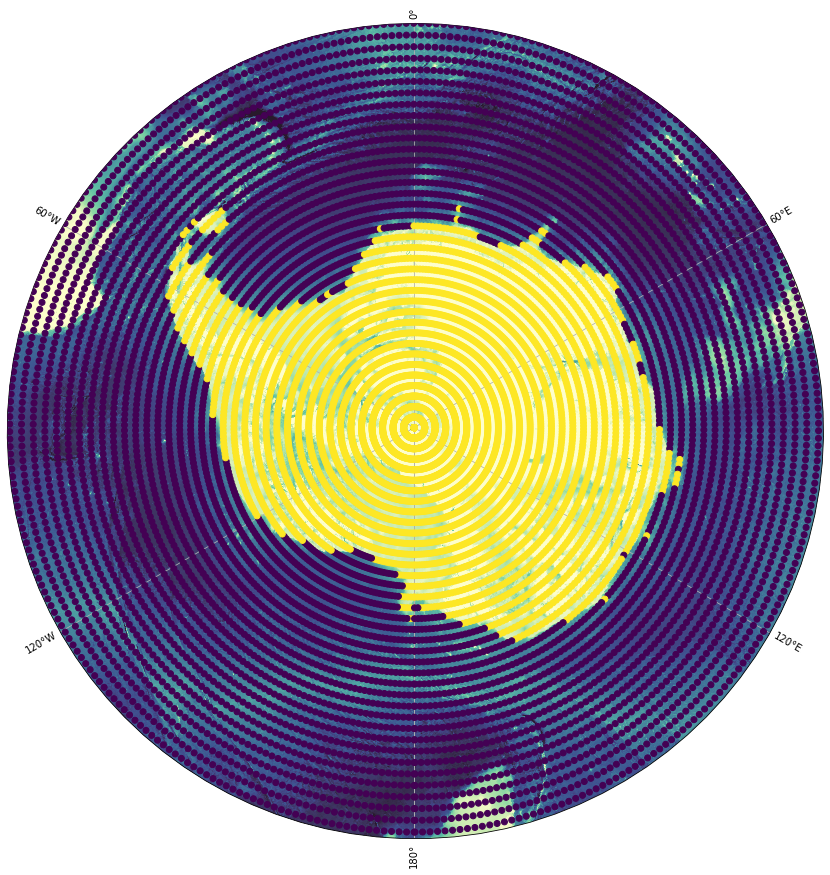

In [3]:
# ---- Visualize output -----
def prepare_plot(figsize=(15, 15), dpi=300):
    """This function returns prepared axes for the polar plot.
    
    Usage:
        fig, ax = prepare_plot()
    """
    
    theta = np.linspace(0, 2*np.pi, 100)
    map_circle = mpath.Path(np.vstack([np.sin(theta), np.cos(theta)]).T * 0.5 + [0.5, 0.5])

    fig = plt.figure(figsize=figsize)
    ax = plt.axes(projection=ccrs.SouthPolarStereo())
    ax.set_extent([-180, 180, -90, -50], ccrs.PlateCarree())
    ax.set_boundary(map_circle, transform=ax.transAxes)
    # ax.coastlines(); 
    gl = ax.gridlines(draw_labels=True, ylocs=[]);#, color='w', lw=2);
    return fig, ax
    
fig, ax = prepare_plot()
cm1 = ax.pcolormesh(IBCSO['lon'][::10], 
                    IBCSO['lat'][::5],
                    IBCSO['z'][::5,::10], 
                    transform=ccrs.PlateCarree(), vmin=-6000, vmax=0, cmap=cmocean.cm.deep_r);

ax.scatter(x_test, y_test, c=boolean_test, zorder=4, transform=ccrs.PlateCarree())